## Outline
1. Using torchvision.datasets with a custom folder of images
2. Occlusion analysis with pretrained model
3. Filter visualisation with pretrained model

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms

## Load dataset

In [3]:
# This is for if we are working in google colab "!" means that whatever is written in front of it is a unix command - here we are unzipping a file
!unzip data.zip

unzip:  cannot find or open data.zip, data.zip.zip or data.zip.ZIP.


In [3]:
with open("data/imagenet_labels.txt") as f:
  classes = eval(f.read())

In [4]:
print(classes) 

{0: 'tench, Tinca tinca', 1: 'goldfish, Carassius auratus', 2: 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias', 3: 'tiger shark, Galeocerdo cuvieri', 4: 'hammerhead, hammerhead shark', 5: 'electric ray, crampfish, numbfish, torpedo', 6: 'stingray', 7: 'cock', 8: 'hen', 9: 'ostrich, Struthio camelus', 10: 'brambling, Fringilla montifringilla', 11: 'goldfinch, Carduelis carduelis', 12: 'house finch, linnet, Carpodacus mexicanus', 13: 'junco, snowbird', 14: 'indigo bunting, indigo finch, indigo bird, Passerina cyanea', 15: 'robin, American robin, Turdus migratorius', 16: 'bulbul', 17: 'jay', 18: 'magpie', 19: 'chickadee', 20: 'water ouzel, dipper', 21: 'kite', 22: 'bald eagle, American eagle, Haliaeetus leucocephalus', 23: 'vulture', 24: 'great grey owl, great gray owl, Strix nebulosa', 25: 'European fire salamander, Salamandra salamandra', 26: 'common newt, Triturus vulgaris', 27: 'eft', 28: 'spotted salamander, Ambystoma maculatum', 29: 'axolotl, mu

In [5]:
transform = transforms.Compose([
    # Matching the input size for our convolutional nets that we are going to use
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

In [6]:
# Specifying the image folder - Dataset has been creaed
evalset = datasets.ImageFolder(root="./data/imagenet/", transform=transform)

In [7]:
batch_size = 1

In [8]:
# Loader created
evalloader = torch.utils.data.DataLoader(evalset, batch_size=batch_size, shuffle=True)

In [9]:
# Creating an iteraor and getting batches out of it.
dataiter = iter(evalloader)
images, labels = dataiter.next()

print(images.shape)
print(images[0].shape)
print(labels[0].item())

torch.Size([1, 3, 224, 224])
torch.Size([3, 224, 224])
0


## Load pretrained model

In [10]:
model = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/avishek/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [13:23<00:00, 688kB/s]    


In [11]:
# Setting a mode here which ensures that certain things like droupout which are channes which are used only during training phase are and not during evaluation are turned off
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## Visualise image

In [12]:
# This fucntion will take a img and a title and will plot it.
def imshow(img, title):
  # Corrections to the dataset that we had transformed. This is so that we can see the images correctly
  std_correction = np.asarray([0.229, 0.224, 0.225]).reshape(3, 1, 1) # Here, we reshape it as 3x3x1 to have pointwise multiplication with the numpy image
  mean_correction = np.asarray([0.485, 0.456, 0.406]).reshape(3, 1, 1)
  npimg = np.multiply(img.numpy(), std_correction) + mean_correction
  
  plt.figure(figsize=(batch_size * 4, 4))
  plt.axis("off")
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.title(title)
  plt.show()

In [13]:
def show_batch_images(dataloader):
  images, _ = next(iter(dataloader))
  outputs = model(images)
  _, pred = torch.max(outputs.data, 1)
  
  img = torchvision.utils.make_grid(images)
  imshow(img, title=[classes[x.item()] for x in pred])
  
  return images, pred

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


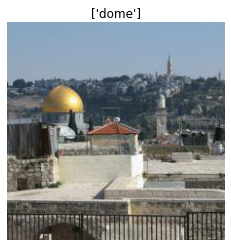

In [24]:
images, pred = show_batch_images(evalloader)

## Occlusion analysis

In [25]:
outputs = model(images)
print(outputs.shape)
outputs = nn.functional.softmax(outputs, dim=1)
prob_no_occ, pred = torch.max(outputs.data, 1)
pob_no_occ = prob_no_occ[0].item()
print(prob_no_occ)

torch.Size([1, 1000])
tensor([0.7955])


In [26]:
# A functioon to create occlusion heat maps
def occlusion(model, image, label, occ_size=50, occ_stride=50, occ_pixel=0.5):
  
  width, height = image.shape[-2], image.shape[-1]
  
  output_height = int(np.ceil((height-occ_size)/occ_stride))
  output_width = int(np.ceil((width-occ_size)/occ_stride))
  
  heatmap = torch.zeros((output_height, output_width))
  
  for h in range(0, height):
    for w in range(0, width):
      
      h_start = h*occ_stride
      w_start = w*occ_stride
      h_end = min(height, h_start + occ_size)
      w_end = min(width, w_start + occ_size)
      
      if (w_end) >= width or (h_end) >= height:
        continue
        
      input_image = image.clone().detach()
      input_image[:, :, w_start:w_end, h_start:h_end] = occ_pixel
      
      output = model(input_image)
      output = nn.functional.softmax(output, dim=1)
      prob = output.tolist()[0][label]
      
      heatmap[h, w] = prob
      
  return heatmap

In [27]:
heatmap = occlusion(model, images, pred[0].item(), 32, 14)

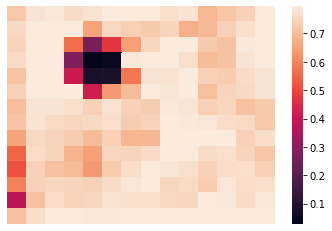

In [28]:
iimgplot = sns.heatmap(heatmap, xticklabels=False, yticklabels=False, vmax=prob_no_occ)
# So as we can see in the hea map if we occlude the refion of the dome then the probability of the classifier decreases drastically.
# In place of that if we take out other regions then then the probability does not remove drastically

## FIlter visualisation

In [29]:
alexnet = models.alexnet(pretrained=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /home/avishek/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [09:00<00:00, 452kB/s]    


In [30]:
print(alexnet)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [31]:
def plot_filters_single_channel_big(t):
    nrows = t.shape[0]*t.shape[2]
    ncols = t.shape[1]*t.shape[3]

    npimg = np.asarray(t.numpy(), np.float32)
    npimg = npimg.transpose((0, 2, 1, 3))
    npimg = npimg.ravel().reshape(nrows, ncols)

    npimg = npimg.T

    fig, ax = plt.subplots(figsize=(ncols/10, nrows/200))

    imgplot = sns.heatmap(npimg, xticklabels=False, yticklabels=False, cmap="Greys", ax=ax, cbar=False)

In [32]:
def plot_filters_single_channel(t):

    nplots = t.shape[0]*t.shape[1]
    ncols = 12
    nrows = 1 + nplots//ncols

    npimg = np.array(t.numpy(), np.float32)

    count = 0

    fig = plt.figure(figsize=(ncols, nrows))
    for i in range(t.shape[0]):
        for j in range(t.shape[1]):
            count += 1
            ax1 = fig.add_subplot(nrows, ncols, count)
            npimg = np.array(t[i, j].numpy(), np.float32)
            npimg = (npimg - np.mean(npimg)) / np.std(npimg)  # Normalising the image
            npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
            ax1.imshow(npimg)
            ax1.set_title(str(i) + ',' + str(j) )
            ax1.axis('off')
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])

    plt.tight_layout()
    plt.show()

In [33]:
def plot_filters_multi_channel(t):
    
    num_kernels = t.shape[0]    
    
    num_cols = 12
    num_rows = num_kernels
    
    fig = plt.figure(figsize=(num_cols,num_rows))
    for i in range(t.shape[0]):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        
        npimg = np.array(t[i].numpy(), np.float32)
        npimg = (npimg - np.mean(npimg)) / np.std(npimg)
        npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
        npimg = npimg.transpose((1, 2, 0))
        ax1.imshow(npimg)
        ax1.axis('off')
        ax1.set_title(str(i))
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])

    plt.tight_layout()
    plt.show()

In [34]:
def plot_weights(model, layer_num, single_channel = True, collated = False):
    
    layer = model.features[layer_num]
    if isinstance(layer, nn.Conv2d):  # Checks if layer is a convolutional layer or not
        weight_tensor = model.features[layer_num].weight.data
        if single_channel:
            if collated:
                plot_filters_single_channel_big(weight_tensor)
            else:
                plot_filters_single_channel(weight_tensor)
        else:
            if weight_tensor.shape[1] == 3:
                plot_filters_multi_channel(weight_tensor)
            else:
                'Can only plot weights with three channels with single_channel = False'
    else:
        print('Can only visualise layers which are convolutional')

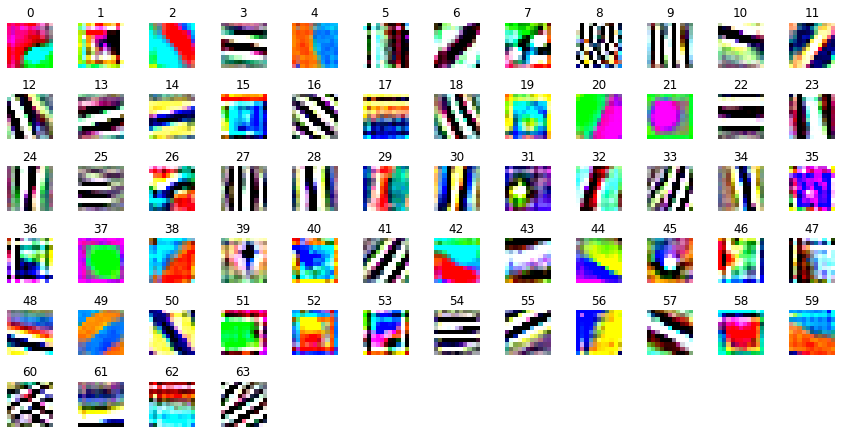

In [35]:
plot_weights(alexnet, 0, single_channel = False)

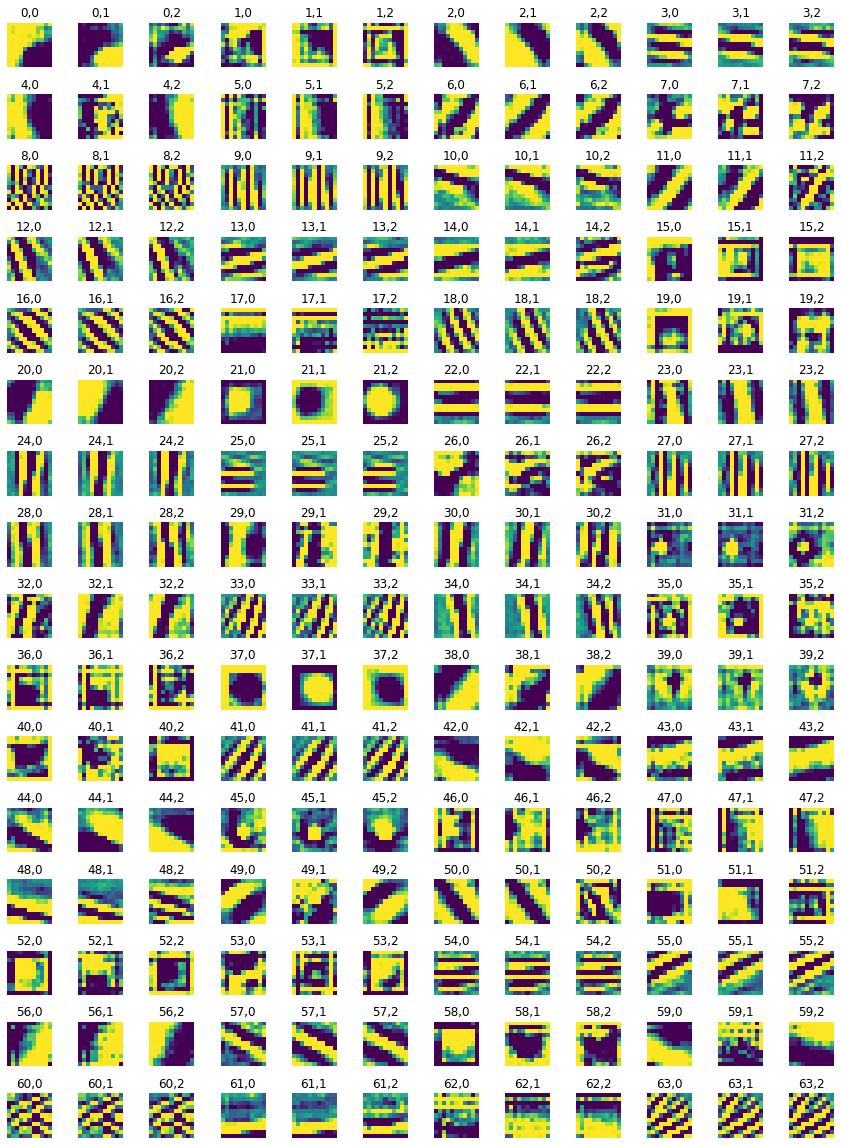

In [36]:
plot_weights(alexnet, 0, single_channel = True)

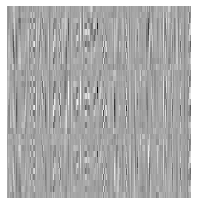

In [37]:
 plot_weights(alexnet, 0, single_channel = True, collated = True)

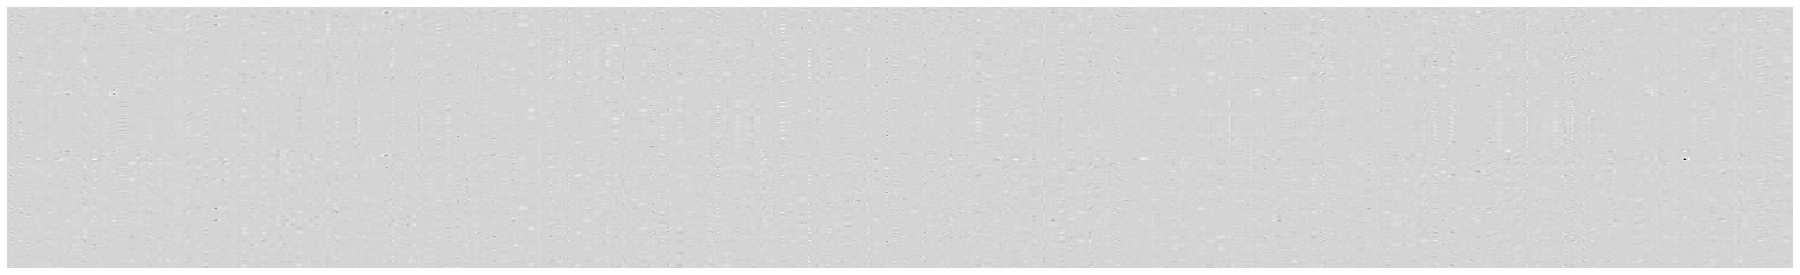

In [38]:
plot_weights(alexnet, 3, single_channel = True, collated = True)

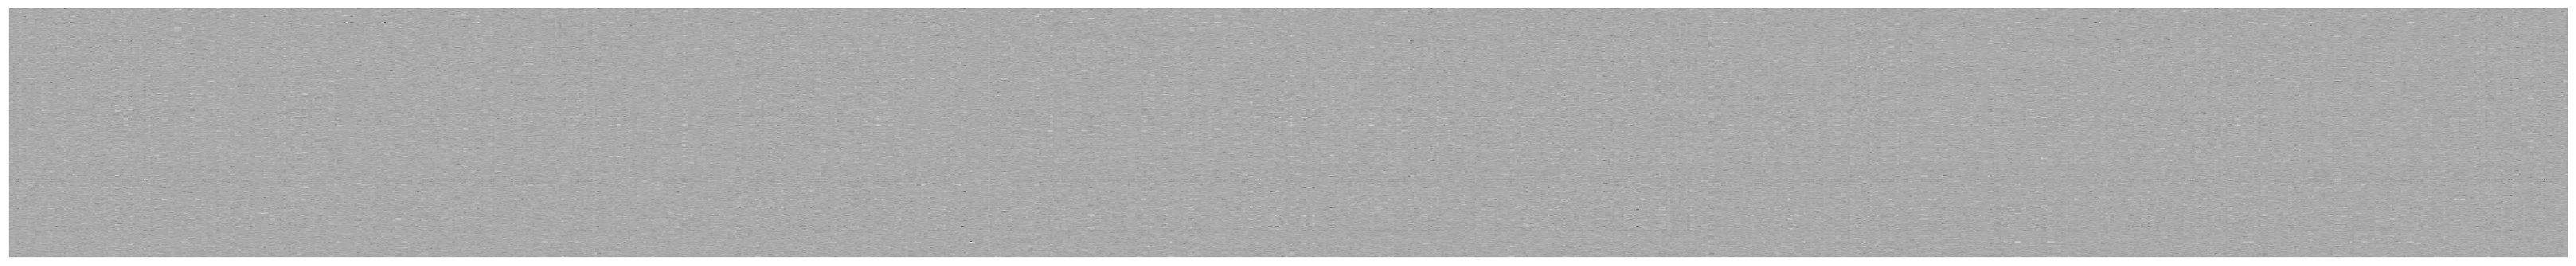

In [46]:
plot_weights(alexnet, 6, single_channel = True, collated = True)

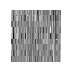

In [47]:
plot_weights(model, 0, single_channel = True, collated = True)

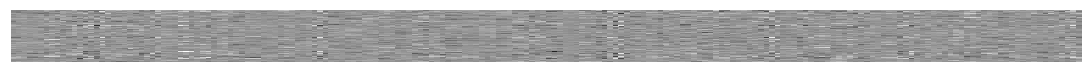

In [48]:
plot_weights(model, 2, single_channel = True, collated = True)

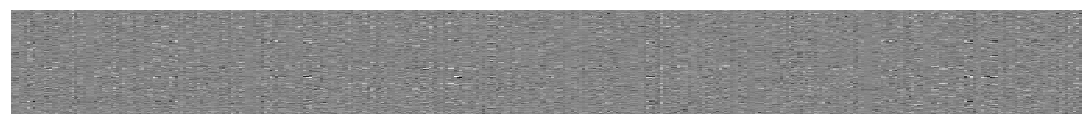

In [49]:
plot_weights(model, 5, single_channel = True, collated = True)

In [50]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [51]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# List .txt files in the root.
#
# Search query reference:
# https://developers.google.com/drive/v2/web/search-parameters
listed = drive.ListFile({'q': "title contains '.txt' and 'root' in parents"}).GetList()
for file in listed:
  print('title {}, id {}'.format(file['title'], file['id']))

title File2.txt, id 1qDh3CJUu__FRK5wAeF5VAVX3KFxw10Fw
title File2.txt, id 1DKZfeVi4YxTIeaLhkx9fxD4x6v8TPOgf
title File2.txt, id 1jrKliOS9rtPJIDp6rj4vcYvkdnxmotWk
title Sample file.txt, id 19eBEKbkvvWkXbWsFfV3Y_t6Bo2fVGOHZ
